# Fine-tuning AraBERT for Multi-Task Arabic Text Classification

This notebook demonstrates how to fine-tune AraBERT model for multi-task classification on Arabic tweets. We'll be classifying:
1. Sarcasm detection (True/False)
2. Sentiment analysis (Positive, Negative, Neutral)
3. Dialect identification (MSA, Gulf, Egyptian, etc.)

AraBERT is pre-trained on MSA (Modern Standard Arabic) text and performs well on formal Arabic text classification tasks.

## 1. Install Required Libraries

In [2]:
# Install required packages
!pip install transformers datasets scikit-learn pandas matplotlib seaborn numpy torch farasapy py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 183.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 176.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 207.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 157.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.7/781.7 kB 110.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 168.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


## 2. Import Libraries

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import (
    AutoTokenizer, 
    AutoModel, 
    AutoConfig,
    get_linear_schedule_with_warmup,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from torch.optim import AdamW
import random
from tqdm.auto import tqdm

# Set random seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 3. Configuration Parameters

Define all hyperparameters and configuration settings in one place for easy modification.

In [5]:
# Model Configuration
CONFIG = {
    # Model parameters
    "MODEL_NAME": "aubmindlab/bert-base-arabertv2",  # Using AraBERT v2
    "MAX_LENGTH": 256,
    "BATCH_SIZE": 16,  # Increase to 32 if memory allows
    "LEARNING_RATE": 2e-5,
    "NUM_EPOCHS": 10,  # Can be reduced to 3
    "WEIGHT_DECAY": 0.01,
    "EVAL_STRATEGY": "epoch",
    "GRAD_CLIP": 1.0,
    "DROPOUT": 0.3,  # Can be tuned between 0.1 and 0.3
    "WARMUP_RATIO": 0.1,
    
    # Task-specific parameters
    "TASKS": ["sarcasm", "sentiment", "dialect"],
    "TASK_TYPES": {
        "sarcasm": "binary",
        "sentiment": "multi",
        "dialect": "multi"
    },
    
    # File paths
    "TRAIN_DATA_PATH": "training_data.csv",
    "TEST_DATA_PATH": "testing_data.csv",
    
    # Output
    "OUTPUT_DIR": "arabert-multitask-output"
}

## 4. Load and Explore the Dataset

In [8]:
# Load datasets
train_df = pd.read_csv(CONFIG["TRAIN_DATA_PATH"])
test_df = pd.read_csv(CONFIG["TEST_DATA_PATH"])

print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

# Display the first few examples
train_df.head()

Training data shape: (12548, 4)
Testing data shape: (3000, 4)


,tweet,sarcasm,sentiment,dialect
0,د محمود_العلايلي أرى أن الفريق أحمد_شفيق رقم م...,False,NEU,msa
1,مع فيدرر يا آجا والكبار,False,NEU,msa
2,الداعون لمبدأ الاختلاط بين الجنسين؛ كالداعين ل...,True,NEG,msa
3,_94 78 5 202 مساكين من الصبح و هوما رايحين راج...,True,NEG,gulf
4,قل شرق حلب ولا تقل حلب الشرقية وقل غرب حلب ولا...,False,NEU,msa


In [9]:
# Testing data statistics
print("Testing data statistics:")
print("\nSarcasm distribution:")
print(test_df["sarcasm"].value_counts())

print("\nSentiment distribution:")
print(test_df["sentiment"].value_counts())

print("\nDialect distribution:")
print(test_df["dialect"].value_counts())

Testing data statistics:

Sarcasm distribution:
sarcasm
False    2179
True      821
Name: count, dtype: int64

Sentiment distribution:
sentiment
NEG    1677
NEU     748
POS     575
Name: count, dtype: int64

Dialect distribution:
dialect
msa       2323
gulf       322
egypt      306
levant      47
magreb       2
Name: count, dtype: int64


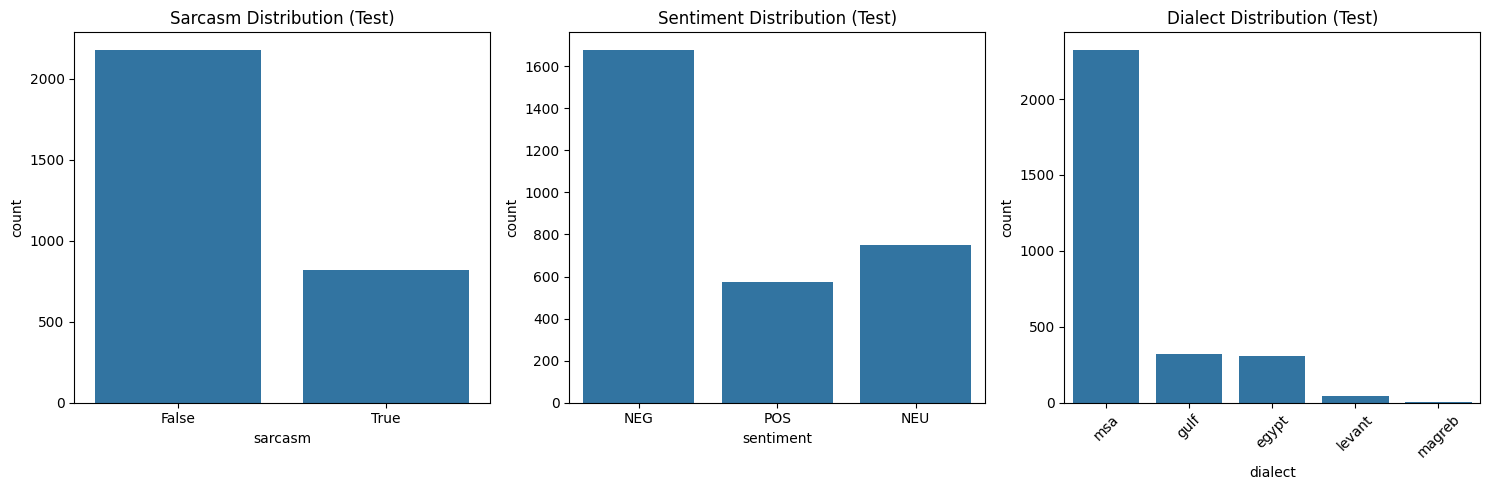

In [10]:
# Visualize class distributions in the test set
plt.figure(figsize=(15, 5))

# Sarcasm
plt.subplot(1, 3, 1)
sns.countplot(x='sarcasm', data=test_df)
plt.title('Sarcasm Distribution (Test)')

# Sentiment
plt.subplot(1, 3, 2)
sns.countplot(x='sentiment', data=test_df)
plt.title('Sentiment Distribution (Test)')

# Dialect
plt.subplot(1, 3, 3)
sns.countplot(x='dialect', data=test_df)
plt.title('Dialect Distribution (Test)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# View the number of null values in each column
print("Null values in training data:")
print(train_df.isnull().sum())

print("\nNull values in testing data:")
print(test_df.isnull().sum())

# Drop rows with any null values
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# Confirm the nulls are dropped
print("\nAfter dropping nulls:")
print("Training data shape:", train_df.shape)
print("Testing data shape:", test_df.shape)

Null values in training data:
tweet        2
sarcasm      0
sentiment    0
dialect      0
dtype: int64

Null values in testing data:
tweet        1
sarcasm      0
sentiment    0
dialect      0
dtype: int64

After dropping nulls:
Training data shape: (12546, 4)
Testing data shape: (2999, 4)


## 5. Preprocess the Data

In [12]:
# Convert sarcasm to 0/1 for binary classification
train_df["sarcasm"] = train_df["sarcasm"].map({False: 0, True: 1})
test_df["sarcasm"] = test_df["sarcasm"].map({False: 0, True: 1})

# Encode sentiment labels
sentiment_encoder = LabelEncoder()
train_df["sentiment_encoded"] = sentiment_encoder.fit_transform(train_df["sentiment"])
test_df["sentiment_encoded"] = sentiment_encoder.transform(test_df["sentiment"])

# Encode dialect labels
dialect_encoder = LabelEncoder()
train_df["dialect_encoded"] = dialect_encoder.fit_transform(train_df["dialect"])
test_df["dialect_encoded"] = dialect_encoder.transform(test_df["dialect"])

# Store the label mappings for reference
sentiment_classes = sentiment_encoder.classes_
dialect_classes = dialect_encoder.classes_

print("Sentiment classes:", dict(zip(range(len(sentiment_classes)), sentiment_classes)))
print("Dialect classes:", dict(zip(range(len(dialect_classes)), dialect_classes)))

Sentiment classes: {0: 'NEG', 1: 'NEU', 2: 'POS'}
Dialect classes: {0: 'egypt', 1: 'gulf', 2: 'levant', 3: 'magreb', 4: 'msa'}


In [13]:
# Calculate class weights for imbalanced classes
sarcasm_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["sarcasm"]),
    y=train_df["sarcasm"]
)

sentiment_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["sentiment_encoded"]),
    y=train_df["sentiment_encoded"]
)

dialect_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["dialect_encoded"]),
    y=train_df["dialect_encoded"]
)

print("Sarcasm class weights:", dict(zip(np.unique(train_df["sarcasm"]), sarcasm_weights)))
print("Sentiment class weights:", dict(zip(np.unique(train_df["sentiment_encoded"]), sentiment_weights)))
print("Dialect class weights:", dict(zip(np.unique(train_df["dialect_encoded"]), dialect_weights)))

Sarcasm class weights: {0: 0.604393486848444, 1: 2.894785417628057}
Sentiment class weights: {0: 0.9051948051948052, 1: 0.727810650887574, 2: 1.918348623853211}
Dialect class weights: {0: 0.938018691588785, 1: 3.896273291925466, 2: 4.0211538461538465, 3: 58.353488372093025, 4: 0.29313084112149534}


## 6. AraBERT Preprocessing and Tokenization

AraBERT includes a specialized preprocessing pipeline for Arabic text. We'll implement that here.

In [14]:
def arabert_preprocess(text):
    """
    Preprocess text for AraBERT following the recommended steps.
    """
    # Remove diacritics (harakaat)
    text = text.strip()
    # Replace some Arabic punctuations with English punctuations
    text = text.replace('،', ',')
    text = text.replace('؛', ';')
    text = text.replace('؟', '?')
    text = text.replace('»', '"')
    text = text.replace('«', '"')
    text = text.replace('\u2018', "'")
    text = text.replace('\u2019', "'")
    # Normalize Alef, Yah, and Tah marbuta
    text = text.replace('أ', 'ا')
    text = text.replace('إ', 'ا')
    text = text.replace('آ', 'ا')
    text = text.replace('ي', 'ى')
    text = text.replace('ة', 'ه')
    
    return text

In [15]:
# Preprocess the texts for AraBERT
train_df["preprocessed_tweet"] = train_df["tweet"].apply(arabert_preprocess)
test_df["preprocessed_tweet"] = test_df["tweet"].apply(arabert_preprocess)

# Display an example of the preprocessing
examples = pd.DataFrame({
    'Original': train_df['tweet'].head(3),
    'Preprocessed': train_df['preprocessed_tweet'].head(3)
})

print("Examples of AraBERT Preprocessing:")
examples

Examples of AraBERT Preprocessing:


,Original,Preprocessed
0,د محمود_العلايلي أرى أن الفريق أحمد_شفيق رقم م...,د محمود_العلاىلى ارى ان الفرىق احمد_شفىق رقم م...
1,مع فيدرر يا آجا والكبار,مع فىدرر ىا اجا والكبار
2,الداعون لمبدأ الاختلاط بين الجنسين؛ كالداعين ل...,الداعون لمبدا الاختلاط بىن الجنسىن; كالداعىن ل...


In [16]:
# Load the AraBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained(CONFIG["MODEL_NAME"])

# Create a PyTorch Dataset for multi-task learning
class ArabicMultiTaskDataset(Dataset):
    def __init__(self, texts, sarcasm_labels, sentiment_labels, dialect_labels, tokenizer, max_length):
        self.texts = texts
        self.sarcasm_labels = sarcasm_labels
        self.sentiment_labels = sentiment_labels
        self.dialect_labels = dialect_labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        sarcasm_label = self.sarcasm_labels[idx]
        sentiment_label = self.sentiment_labels[idx]
        dialect_label = self.dialect_labels[idx]
        
        encoding = self.tokenizer(
            text, 
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt"
        )
        
        # Remove the batch dimension
        encoding = {k: v.squeeze(0) for k, v in encoding.items()}
        
        return {
            'input_ids': encoding['input_ids'],
            'attention_mask': encoding['attention_mask'],
            'sarcasm_label': torch.tensor(sarcasm_label, dtype=torch.long),
            'sentiment_label': torch.tensor(sentiment_label, dtype=torch.long),
            'dialect_label': torch.tensor(dialect_label, dtype=torch.long)
        }

tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/720k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [17]:
# Create training and testing datasets using preprocessed tweets
train_dataset = ArabicMultiTaskDataset(
    texts=train_df["preprocessed_tweet"].tolist(),
    sarcasm_labels=train_df["sarcasm"].tolist(),
    sentiment_labels=train_df["sentiment_encoded"].tolist(),
    dialect_labels=train_df["dialect_encoded"].tolist(),
    tokenizer=tokenizer,
    max_length=CONFIG["MAX_LENGTH"]
)

test_dataset = ArabicMultiTaskDataset(
    texts=test_df["preprocessed_tweet"].tolist(),
    sarcasm_labels=test_df["sarcasm"].tolist(),
    sentiment_labels=test_df["sentiment_encoded"].tolist(),
    dialect_labels=test_df["dialect_encoded"].tolist(),
    tokenizer=tokenizer,
    max_length=CONFIG["MAX_LENGTH"]
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG["BATCH_SIZE"],
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG["BATCH_SIZE"],
    shuffle=False
)

## 7. Define Multi-Task Model Architecture

We'll create a model with one shared encoder (AraBERT) and three separate classification heads.

In [18]:
class AraBERTMultiTaskModel(nn.Module):
    def __init__(self, model_name, num_sentiment_labels, num_dialect_labels, dropout=0.3):
        super(AraBERTMultiTaskModel, self).__init__()
        
        # Load pre-trained AraBERT model
        self.encoder = AutoModel.from_pretrained(model_name)
        self.hidden_size = self.encoder.config.hidden_size
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Task-specific classification heads
        self.sarcasm_classifier = nn.Linear(self.hidden_size, 2)  # Binary classification
        self.sentiment_classifier = nn.Linear(self.hidden_size, num_sentiment_labels)
        self.dialect_classifier = nn.Linear(self.hidden_size, num_dialect_labels)
        
    def forward(self, input_ids, attention_mask):
        # Get encoder output
        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # Get the [CLS] token embedding (the first token)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)
        
        # Task-specific predictions
        sarcasm_logits = self.sarcasm_classifier(pooled_output)
        sentiment_logits = self.sentiment_classifier(pooled_output)
        dialect_logits = self.dialect_classifier(pooled_output)
        
        return sarcasm_logits, sentiment_logits, dialect_logits

## 8. Training Function with Multi-Task Learning

In [19]:
def train_multi_task_model(model, train_loader, test_loader, config, device):
    # Set up optimizer with weight decay
    optimizer = AdamW(
        model.parameters(),
        lr=config["LEARNING_RATE"],
        weight_decay=config["WEIGHT_DECAY"]
    )
    
    # Calculate total training steps for learning rate scheduler
    total_steps = len(train_loader) * config["NUM_EPOCHS"]
    warmup_steps = int(total_steps * config["WARMUP_RATIO"])
    
    # Set up scheduler with linear warmup
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )
    
    # Convert class weights to tensors and move to device
    sarcasm_weights_tensor = torch.tensor(sarcasm_weights, dtype=torch.float).to(device)
    sentiment_weights_tensor = torch.tensor(sentiment_weights, dtype=torch.float).to(device)
    dialect_weights_tensor = torch.tensor(dialect_weights, dtype=torch.float).to(device)
    
    # Define loss functions with class weights
    sarcasm_loss_fn = nn.CrossEntropyLoss(weight=sarcasm_weights_tensor)
    sentiment_loss_fn = nn.CrossEntropyLoss(weight=sentiment_weights_tensor)
    dialect_loss_fn = nn.CrossEntropyLoss(weight=dialect_weights_tensor)
    
    # Training history
    history = {
        'train_loss': [],
        'sarcasm_f1': [],
        'sentiment_f1': [],
        'dialect_f1': []
    }
    
    # Training loop
    for epoch in range(config["NUM_EPOCHS"]):
        model.train()
        total_loss = 0
        
        train_progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['NUM_EPOCHS']}")
        
        for batch in train_progress_bar:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            sarcasm_labels = batch['sarcasm_label'].to(device)
            sentiment_labels = batch['sentiment_label'].to(device)
            dialect_labels = batch['dialect_label'].to(device)
            
            # Clear gradients
            optimizer.zero_grad()
            
            # Forward pass
            sarcasm_logits, sentiment_logits, dialect_logits = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            # Calculate losses for each task
            sarcasm_loss = sarcasm_loss_fn(sarcasm_logits, sarcasm_labels)
            sentiment_loss = sentiment_loss_fn(sentiment_logits, sentiment_labels)
            dialect_loss = dialect_loss_fn(dialect_logits, dialect_labels)
            
            # Equal task weighting for AraBERT
            loss = sarcasm_loss + sentiment_loss + dialect_loss
            
            # Backward pass
            loss.backward()
            
            # Clip gradients to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), config["GRAD_CLIP"])
            
            # Update parameters
            optimizer.step()
            
            # Update learning rate
            scheduler.step()
            
            # Update total loss
            total_loss += loss.item()
            
            # Update progress bar
            train_progress_bar.set_postfix({
                'loss': loss.item(),
                'sarcasm_loss': sarcasm_loss.item(),
                'sentiment_loss': sentiment_loss.item(),
                'dialect_loss': dialect_loss.item()
            })
        
        # Calculate average loss per epoch
        avg_train_loss = total_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)
        
        print(f"\nEpoch {epoch+1}/{config['NUM_EPOCHS']}, Training Loss: {avg_train_loss:.4f}")
        
        # Evaluate on test set
        sarcasm_f1, sentiment_f1, dialect_f1 = evaluate_model(model, test_loader, device)
        
        # Store metrics
        history['sarcasm_f1'].append(sarcasm_f1)
        history['sentiment_f1'].append(sentiment_f1)
        history['dialect_f1'].append(dialect_f1)
        
        print(f"Sarcasm F1: {sarcasm_f1:.4f}, Sentiment F1: {sentiment_f1:.4f}, Dialect F1: {dialect_f1:.4f}\n")
    
    return model, history

## 9. Evaluation Function

In [20]:
def evaluate_model(model, data_loader, device):
    model.eval()
    
    sarcasm_preds = []
    sarcasm_true = []
    sentiment_preds = []
    sentiment_true = []
    dialect_preds = []
    dialect_true = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            sarcasm_labels = batch['sarcasm_label'].cpu().numpy()
            sentiment_labels = batch['sentiment_label'].cpu().numpy()
            dialect_labels = batch['dialect_label'].cpu().numpy()
            
            # Forward pass
            sarcasm_logits, sentiment_logits, dialect_logits = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            # Get predictions
            sarcasm_batch_preds = torch.argmax(sarcasm_logits, dim=1).cpu().numpy()
            sentiment_batch_preds = torch.argmax(sentiment_logits, dim=1).cpu().numpy()
            dialect_batch_preds = torch.argmax(dialect_logits, dim=1).cpu().numpy()
            
            # Store predictions and true labels
            sarcasm_preds.extend(sarcasm_batch_preds)
            sarcasm_true.extend(sarcasm_labels)
            sentiment_preds.extend(sentiment_batch_preds)
            sentiment_true.extend(sentiment_labels)
            dialect_preds.extend(dialect_batch_preds)
            dialect_true.extend(dialect_labels)
    
    # Calculate F1 scores
    sarcasm_f1 = f1_score(sarcasm_true, sarcasm_preds, average='weighted')
    sentiment_f1 = f1_score(sentiment_true, sentiment_preds, average='weighted')
    dialect_f1 = f1_score(dialect_true, dialect_preds, average='weighted')
    
    return sarcasm_f1, sentiment_f1, dialect_f1

## 10. Detailed Evaluation and Visualization

In [21]:
def detailed_evaluation(model, data_loader, device, sentiment_encoder, dialect_encoder):
    model.eval()
    
    # Predictions and true labels
    sarcasm_preds = []
    sarcasm_true = []
    sentiment_preds = []
    sentiment_true = []
    dialect_preds = []
    dialect_true = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Detailed Evaluation"):
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            sarcasm_labels = batch['sarcasm_label'].cpu().numpy()
            sentiment_labels = batch['sentiment_label'].cpu().numpy()
            dialect_labels = batch['dialect_label'].cpu().numpy()
            
            # Forward pass
            sarcasm_logits, sentiment_logits, dialect_logits = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            # Get predictions
            sarcasm_batch_preds = torch.argmax(sarcasm_logits, dim=1).cpu().numpy()
            sentiment_batch_preds = torch.argmax(sentiment_logits, dim=1).cpu().numpy()
            dialect_batch_preds = torch.argmax(dialect_logits, dim=1).cpu().numpy()
            
            # Store predictions and true labels
            sarcasm_preds.extend(sarcasm_batch_preds)
            sarcasm_true.extend(sarcasm_labels)
            sentiment_preds.extend(sentiment_batch_preds)
            sentiment_true.extend(sentiment_labels)
            dialect_preds.extend(dialect_batch_preds)
            dialect_true.extend(dialect_labels)
    
    # Print classification reports
    print("\nSarcasm Classification Report:")
    print(classification_report(
        sarcasm_true, sarcasm_preds, 
        target_names=["Not Sarcastic", "Sarcastic"]
    ))
    
    print("\nSentiment Classification Report:")
    print(classification_report(
        sentiment_true, sentiment_preds, 
        target_names=sentiment_encoder.classes_
    ))
    
    print("\nDialect Classification Report:")
    print(classification_report(
        dialect_true, dialect_preds, 
        target_names=dialect_encoder.classes_
    ))
    
    # Draw confusion matrices
    plt.figure(figsize=(20, 5))
    
    # Sarcasm confusion matrix
    plt.subplot(1, 3, 1)
    sarcasm_cm = confusion_matrix(sarcasm_true, sarcasm_preds)
    sns.heatmap(sarcasm_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Sarcastic", "Sarcastic"], yticklabels=["Not Sarcastic", "Sarcastic"])
    plt.title("Sarcasm Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    
    # Sentiment confusion matrix
    plt.subplot(1, 3, 2)
    sentiment_cm = confusion_matrix(sentiment_true, sentiment_preds)
    sns.heatmap(sentiment_cm, annot=True, fmt="d", cmap="Blues", xticklabels=sentiment_encoder.classes_, yticklabels=sentiment_encoder.classes_)
    plt.title("Sentiment Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    
    # Dialect confusion matrix
    plt.subplot(1, 3, 3)
    dialect_cm = confusion_matrix(dialect_true, dialect_preds)
    sns.heatmap(dialect_cm, annot=True, fmt="d", cmap="Blues", xticklabels=dialect_encoder.classes_, yticklabels=dialect_encoder.classes_)
    plt.title("Dialect Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    
    plt.tight_layout()
    plt.show()
    
    return {
        'sarcasm_f1': f1_score(sarcasm_true, sarcasm_preds, average='weighted'),
        'sentiment_f1': f1_score(sentiment_true, sentiment_preds, average='weighted'),
        'dialect_f1': f1_score(dialect_true, dialect_preds, average='weighted'),
        'sarcasm_accuracy': accuracy_score(sarcasm_true, sarcasm_preds),
        'sentiment_accuracy': accuracy_score(sentiment_true, sentiment_preds),
        'dialect_accuracy': accuracy_score(dialect_true, dialect_preds)
    }

## 11. Model Training

In [22]:
# Initialize the model
model = AraBERTMultiTaskModel(
    model_name=CONFIG["MODEL_NAME"],
    num_sentiment_labels=len(sentiment_classes),
    num_dialect_labels=len(dialect_classes),
    dropout=CONFIG["DROPOUT"]
)

# Move model to device
model = model.to(device)

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Trainable parameters: 135,201,034


In [23]:
# Train the model
trained_model, history = train_multi_task_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    config=CONFIG,
    device=device
)

Epoch 1/5:   0%|          | 0/785 [00:00<?, ?it/s]


Epoch 1/5, Training Loss: 2.8120


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Sarcasm F1: 0.6745, Sentiment F1: 0.6108, Dialect F1: 0.4864



Epoch 2/5:   0%|          | 0/785 [00:00<?, ?it/s]


Epoch 2/5, Training Loss: 2.2470


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Sarcasm F1: 0.7272, Sentiment F1: 0.6064, Dialect F1: 0.5848



Epoch 3/5:   0%|          | 0/785 [00:00<?, ?it/s]


Epoch 3/5, Training Loss: 1.8792


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Sarcasm F1: 0.7394, Sentiment F1: 0.6297, Dialect F1: 0.6155



Epoch 4/5:   0%|          | 0/785 [00:00<?, ?it/s]


Epoch 4/5, Training Loss: 1.6188


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Sarcasm F1: 0.7465, Sentiment F1: 0.6274, Dialect F1: 0.6112



Epoch 5/5:   0%|          | 0/785 [00:00<?, ?it/s]


Epoch 5/5, Training Loss: 1.4110


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Sarcasm F1: 0.7437, Sentiment F1: 0.6259, Dialect F1: 0.6142



## 12. Plot Training History

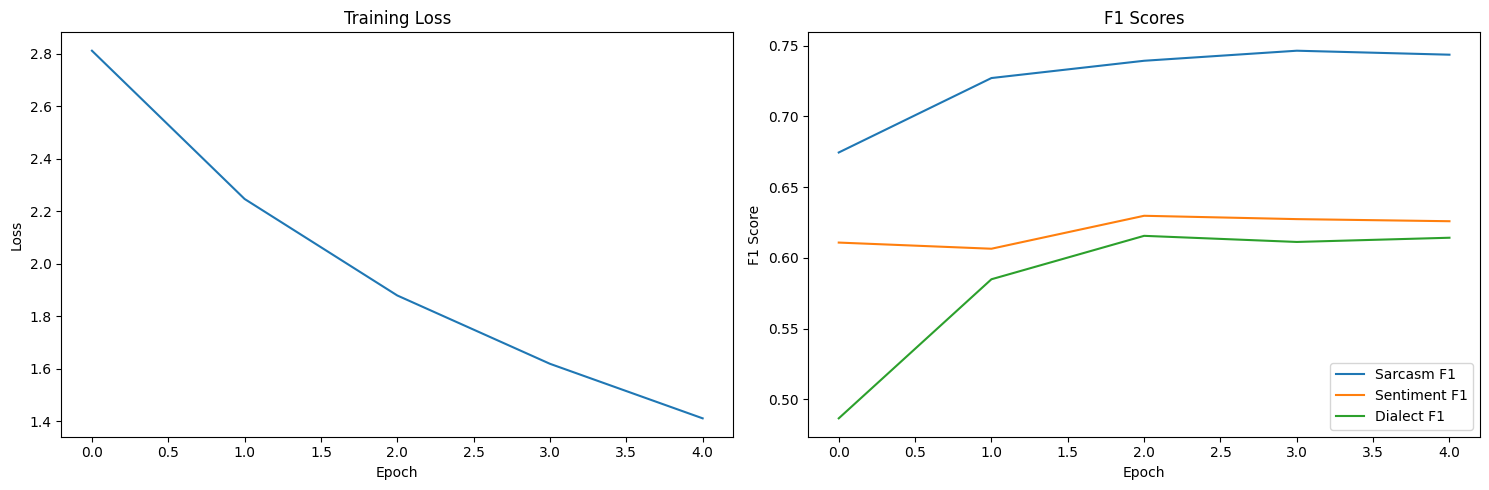

In [24]:
# Plot training loss and F1 scores
plt.figure(figsize=(15, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot F1 scores
plt.subplot(1, 2, 2)
plt.plot(history['sarcasm_f1'], label='Sarcasm F1')
plt.plot(history['sentiment_f1'], label='Sentiment F1')
plt.plot(history['dialect_f1'], label='Dialect F1')
plt.title('F1 Scores')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

## 13. Detailed Evaluation on Test Set

Detailed Evaluation:   0%|          | 0/188 [00:00<?, ?it/s]


Sarcasm Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.85      0.78      0.81      2178
    Sarcastic       0.51      0.63      0.57       821

     accuracy                           0.74      2999
    macro avg       0.68      0.70      0.69      2999
 weighted avg       0.76      0.74      0.74      2999


Sentiment Classification Report:
              precision    recall  f1-score   support

         NEG       0.77      0.70      0.73      1677
         NEU       0.51      0.38      0.43       747
         POS       0.46      0.74      0.57       575

    accuracy                           0.63      2999
   macro avg       0.58      0.61      0.58      2999
weighted avg       0.64      0.63      0.63      2999


Dialect Classification Report:
              precision    recall  f1-score   support

       egypt       0.26      0.79      0.39       306
        gulf       0.32      0.51      0.39       322
      levant       0.13  

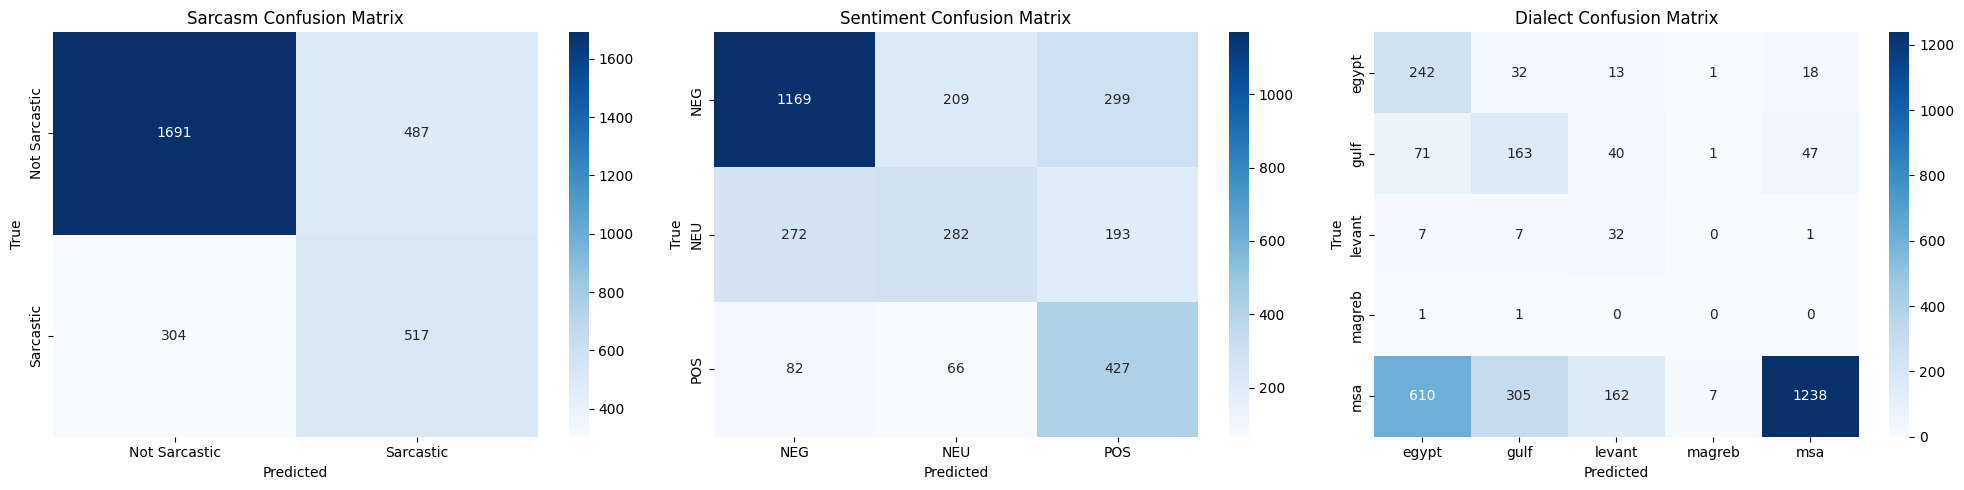


Test Metrics:
sarcasm_f1: 0.7437
sentiment_f1: 0.6259
dialect_f1: 0.6142
sarcasm_accuracy: 0.7362
sentiment_accuracy: 0.6262
dialect_accuracy: 0.5585


In [25]:
# Perform detailed evaluation
test_metrics = detailed_evaluation(
    model=trained_model,
    data_loader=test_loader,
    device=device,
    sentiment_encoder=sentiment_encoder,
    dialect_encoder=dialect_encoder
)

print("\nTest Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

## 14. Save the Model

In [26]:
# Create output directory if it doesn't exist
os.makedirs(CONFIG["OUTPUT_DIR"], exist_ok=True)

# Save model weights
torch.save(trained_model.state_dict(), os.path.join(CONFIG["OUTPUT_DIR"], "arabert_multitask_model.pt"))

# Save label encoders and configuration for later use
import pickle

with open(os.path.join(CONFIG["OUTPUT_DIR"], "sentiment_encoder.pkl"), "wb") as f:
    pickle.dump(sentiment_encoder, f)

with open(os.path.join(CONFIG["OUTPUT_DIR"], "dialect_encoder.pkl"), "wb") as f:
    pickle.dump(dialect_encoder, f)

with open(os.path.join(CONFIG["OUTPUT_DIR"], "config.pkl"), "wb") as f:
    pickle.dump(CONFIG, f)

print(f"Model and configurations saved to {CONFIG['OUTPUT_DIR']}")

Model and configurations saved to arabert-multitask-output


## 15. Example Function to Make Predictions on New Data

In [27]:
def predict_text(text, model, tokenizer, sentiment_encoder, dialect_encoder, device, max_length=256):
    model.eval()
    
    # Preprocess the input text for AraBERT
    preprocessed_text = arabert_preprocess(text)
    
    # Tokenize the preprocessed text
    encoding = tokenizer(
        preprocessed_text,
        truncation=True,
        max_length=max_length,
        padding="max_length",
        return_tensors="pt"
    )
    
    # Move input to device
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)
    
    # Make predictions
    with torch.no_grad():
        sarcasm_logits, sentiment_logits, dialect_logits = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
    
    # Get prediction classes
    sarcasm_pred = torch.argmax(sarcasm_logits, dim=1).item()
    sentiment_pred = torch.argmax(sentiment_logits, dim=1).item()
    dialect_pred = torch.argmax(dialect_logits, dim=1).item()
    
    # Convert numeric predictions to human-readable labels
    sarcasm_label = "Sarcastic" if sarcasm_pred == 1 else "Not Sarcastic"
    sentiment_label = sentiment_encoder.inverse_transform([sentiment_pred])[0]
    dialect_label = dialect_encoder.inverse_transform([dialect_pred])[0]
    
    # Get probabilities
    sarcasm_probs = torch.softmax(sarcasm_logits, dim=1)[0].cpu().numpy()
    sentiment_probs = torch.softmax(sentiment_logits, dim=1)[0].cpu().numpy()
    dialect_probs = torch.softmax(dialect_logits, dim=1)[0].cpu().numpy()
    
    return {
        "text": text,
        "sarcasm": {
            "prediction": sarcasm_label,
            "probability": sarcasm_probs[sarcasm_pred]
        },
        "sentiment": {
            "prediction": sentiment_label,
            "probability": sentiment_probs[sentiment_pred]
        },
        "dialect": {
            "prediction": dialect_label,
            "probability": dialect_probs[dialect_pred]
        }
    }

In [29]:
# Try the prediction function on a few examples
example_texts = [
    "اخوي حانق يالغلا وشفيك معصب؟ عادي تراهم بشر يفطرون الصبح قلابة وتميس تيك ات ايزي مان",
    "أف مو متعوده عليهم سته 8126",
    "اللهم اشفِ مرضانا ومرضى المسلمين",
    "هههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههه بس الصدق أنه وضع فريقك العالمي الأول"
]

for text in example_texts:
    prediction = predict_text(
        text=text,
        model=trained_model,
        tokenizer=tokenizer,
        sentiment_encoder=sentiment_encoder,
        dialect_encoder=dialect_encoder,
        device=device
    )
    
    print(f"\nText: {prediction['text']}")
    print(f"Sarcasm: {prediction['sarcasm']['prediction']} (Probability: {prediction['sarcasm']['probability']:.4f})")
    print(f"Sentiment: {prediction['sentiment']['prediction']} (Probability: {prediction['sentiment']['probability']:.4f})")
    print(f"Dialect: {prediction['dialect']['prediction']} (Probability: {prediction['dialect']['probability']:.4f})")
    print("-" * 80)


Text: اخوي حانق يالغلا وشفيك معصب؟ عادي تراهم بشر يفطرون الصبح قلابة وتميس تيك ات ايزي مان
Sarcasm: Sarcastic (Probability: 0.8764)
Sentiment: NEG (Probability: 0.8661)
Dialect: gulf (Probability: 0.9233)
--------------------------------------------------------------------------------

Text: أف مو متعوده عليهم سته 8126
Sarcasm: Not Sarcastic (Probability: 0.7658)
Sentiment: NEG (Probability: 0.5162)
Dialect: gulf (Probability: 0.8939)
--------------------------------------------------------------------------------

Text: اللهم اشفِ مرضانا ومرضى المسلمين
Sarcasm: Not Sarcastic (Probability: 0.9873)
Sentiment: POS (Probability: 0.8539)
Dialect: msa (Probability: 0.7168)
--------------------------------------------------------------------------------

Text: هههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههههه بس الصدق أنه وضع فريقك العالمي الأول
Sarcasm: Sarcastic (Probability: 0.8600)
Sentiment: NEG (Probability: 0.7583)
Dialect: egypt (Probability:

## 16. Conclusion and Next Steps

We've successfully implemented a multi-task learning model using AraBERT for Arabic text classification. The model can simultaneously predict sarcasm, sentiment, and dialect from Arabic tweets.

### Possible Next Steps:

1. **Hyperparameter Tuning**: Experiment with different learning rates, batch sizes, and dropout values to improve performance.
2. **Model Variants**: Try different pre-trained Arabic language models like CamelBERT, MarBERT, or AraELECTRA.
3. **Task Weighting**: Apply different weights to each task's loss function based on their importance.
4. **Data Augmentation**: Use techniques like back-translation or synonym replacement to increase the size of the training set.
5. **Ensemble Models**: Train multiple models and combine their predictions for better performance.
6. **Error Analysis**: Analyze misclassified examples to understand model limitations.
7. **Deployment**: Deploy the model using frameworks like TensorFlow Serving or TorchServe.